## NHL Season Outcome Multiple Linear Regression EDA

### Description

The following EDA analysis explores NHL team season data from 1983 to 2021.

The data will be used to predict season outcomes. 

Season outcomes are calculated by how many adjusted games a team wins **(wins + (ties / 2))** above the average adjusted wins of any given season (positive deviation). The season outcome (target variable) is calculated in this fashion to capture the varying nature of hockey (acts as a standardized score); in some seasons, teams are closer in regards to games won, and some have a more significant divide. In addition, some seasons are longer than other seasons. By using the adjusted games, a team wins **(wins + (ties / 2))** above the mean adjusted wins of any given season metric; all seasons were included in the analysis despite some seasons having fewer games played (shortened due to strike or the COVID-19 pandemic).

By predicting and understanding what variables can help predict season outcomes in terms of positive deviations from adjusted wins, we can get a deeper look into a metric that may be indicative of teams making the playoffs or not.

NHL team organizations can greater their chances of achieving successful campaigns leading to increased revenue for all stakeholders through ticket sales, salary increases, endorsement deals, the fair book value of the organization, more significant economic activity for the represented city, larger city morale, etc.

In [1]:
# Import libraries
import psycopg2 as ps
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from scipy.stats.mstats import normaltest

import warnings
warnings.filterwarnings('ignore')

from Preprocessing_Functions import *

### Data Preprocessing, Feature Engineering, and Selection

In [2]:
# Connect to database and get nhl_view
try:
    conn = ps.connect('''host=localhost
                         dbname=nhldb
                         user=postgres
                         password=iEchu133
                         ''')
    cur = conn.cursor()

    print('Successfully connected to nhldb.')

except ps.Error as e:
    print('\n Database Error:')
    print(e)
    
query = '''SELECT *
           FROM nhl_view;'''

cur.execute(query)
nhl_df = cur.fetchall()

nhl_df_columns = [
    'team',
    'season_year_range',
    'games_played',
    'wins',
    'losses',
    'ot',
    'pts',
    'pt_pctg',
    'goals_per_game',
    'goals_against_per_game',
    'evgga_ratio',
    'power_play_percentage',
    'power_play_goals',
    'power_play_goals_against',
    'power_play_opportunities',
    'penalty_kill_percentage',
    'shots_per_game',
    'shots_allowed',
    'win_score_first',
    'win_opp_score_first',
    'win_lead_first_per',
    'win_lead_second_per',
    'win_outshoot_opp',
    'win_outshot_by_opp',
    'face_offs_taken',
    'face_offs_won',
    'face_offs_lost',
    'face_off_win_percentage',
    'shooting_pctg',
    'save_pctg',
    'failed_shots_per_game',
    'saves_per_game',
    'ties',
    'power_play_efficiency',
    'made_playoffs',
    'adjWins'
]

nhl_df = pd.DataFrame( nhl_df, columns = nhl_df_columns)

conn.close()

# Claculate and remove adjusted wins outliers
outliers = remove_outliers(df = nhl_df, col = 'adjWins')
nhl_df = nhl_df.loc[(nhl_df['adjWins'] > outliers[1]) & (nhl_df['adjWins'] < outliers[3])].reset_index(drop = True)

nhl_df.info()
nhl_df.head()

Successfully connected to nhldb.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   team                      922 non-null    object 
 1   season_year_range         922 non-null    int64  
 2   games_played              922 non-null    int64  
 3   wins                      922 non-null    int64  
 4   losses                    922 non-null    int64  
 5   ot                        922 non-null    int64  
 6   pts                       922 non-null    int64  
 7   pt_pctg                   922 non-null    float64
 8   goals_per_game            922 non-null    float64
 9   goals_against_per_game    922 non-null    float64
 10  evgga_ratio               922 non-null    float64
 11  power_play_percentage     922 non-null    float64
 12  power_play_goals          922 non-null    int64  
 13  power_play_goals_against  922 no

,team,season_year_range,games_played,wins,losses,ot,pts,pt_pctg,goals_per_game,goals_against_per_game,evgga_ratio,power_play_percentage,power_play_goals,power_play_goals_against,power_play_opportunities,penalty_kill_percentage,shots_per_game,shots_allowed,win_score_first,win_opp_score_first,win_lead_first_per,win_lead_second_per,win_outshoot_opp,win_outshot_by_opp,face_offs_taken,face_offs_won,face_offs_lost,face_off_win_percentage,shooting_pctg,save_pctg,failed_shots_per_game,saves_per_game,ties,power_play_efficiency,made_playoffs,adjWins
0,New Jersey Devils,19831984,80,17,56,0,41,25.6,2.888,4.375,0.6780,14.3,52,83,363,75.3,26.3875,32.0000,0.464,0.077,0.571,0.765,0.348,0.188,0,0,0,0.0,10.9,0.863,23.511263,27.616000,7,-0.085399,0,20.5
1,New York Islanders,19831984,80,50,26,0,104,65.0,4.463,3.363,1.3722,22.5,63,66,280,81.5,30.2750,33.3875,0.791,0.432,0.853,0.933,0.857,0.532,0,0,0,0.0,14.7,0.899,25.824575,30.015363,4,-0.010714,1,52.0
2,New York Rangers,19831984,80,42,29,0,93,58.1,3.925,3.800,1.0392,25.1,74,76,295,78.1,31.8875,31.5500,0.619,0.421,0.828,0.969,0.675,0.467,0,0,0,0.0,12.3,0.880,27.965338,27.764000,9,-0.006780,1,46.5
3,Philadelphia Flyers,19831984,80,44,26,0,98,61.3,4.375,3.625,1.3646,20.2,64,85,317,76.6,36.7500,28.6500,0.667,0.400,0.813,0.875,0.720,0.286,0,0,0,0.0,11.9,0.873,32.376750,25.011450,10,-0.066246,1,49.0
4,Pittsburgh Penguins,19831984,80,16,58,0,38,23.8,3.175,4.875,0.6466,20.9,71,86,339,76.0,28.3375,36.3500,0.316,0.095,0.421,0.737,0.364,0.183,0,0,0,0.0,11.2,0.866,25.163700,31.479100,6,-0.044248,0,19.0


In [3]:
# Convert year range feature into a string data type
nhl_df['season_year_range'] = nhl_df['season_year_range'].astype(str)

# Claculate and remove adjusted wins outliers
outliers = remove_outliers(df = nhl_df, col = 'adjWins')
nhl_df = nhl_df.loc[(nhl_df['adjWins'] > outliers[1]) & (nhl_df['adjWins'] < outliers[3])].reset_index(drop = True)

# Print data summary
print('\n')
nhl_df.info()
nhl_df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   team                      922 non-null    object 
 1   season_year_range         922 non-null    object 
 2   games_played              922 non-null    int64  
 3   wins                      922 non-null    int64  
 4   losses                    922 non-null    int64  
 5   ot                        922 non-null    int64  
 6   pts                       922 non-null    int64  
 7   pt_pctg                   922 non-null    float64
 8   goals_per_game            922 non-null    float64
 9   goals_against_per_game    922 non-null    float64
 10  evgga_ratio               922 non-null    float64
 11  power_play_percentage     922 non-null    float64
 12  power_play_goals          922 non-null    int64  
 13  power_play_goals_against  922 non-null    int64  
 14  power_pl

,team,season_year_range,games_played,wins,losses,ot,pts,pt_pctg,goals_per_game,goals_against_per_game,evgga_ratio,power_play_percentage,power_play_goals,power_play_goals_against,power_play_opportunities,penalty_kill_percentage,shots_per_game,shots_allowed,win_score_first,win_opp_score_first,win_lead_first_per,win_lead_second_per,win_outshoot_opp,win_outshot_by_opp,face_offs_taken,face_offs_won,face_offs_lost,face_off_win_percentage,shooting_pctg,save_pctg,failed_shots_per_game,saves_per_game,ties,power_play_efficiency,made_playoffs,adjWins
0,New Jersey Devils,19831984,80,17,56,0,41,25.6,2.888,4.375,0.6780,14.3,52,83,363,75.3,26.3875,32.0000,0.464,0.077,0.571,0.765,0.348,0.188,0,0,0,0.0,10.9,0.863,23.511263,27.616000,7,-0.085399,0,20.5
1,New York Islanders,19831984,80,50,26,0,104,65.0,4.463,3.363,1.3722,22.5,63,66,280,81.5,30.2750,33.3875,0.791,0.432,0.853,0.933,0.857,0.532,0,0,0,0.0,14.7,0.899,25.824575,30.015363,4,-0.010714,1,52.0
2,New York Rangers,19831984,80,42,29,0,93,58.1,3.925,3.800,1.0392,25.1,74,76,295,78.1,31.8875,31.5500,0.619,0.421,0.828,0.969,0.675,0.467,0,0,0,0.0,12.3,0.880,27.965338,27.764000,9,-0.006780,1,46.5
3,Philadelphia Flyers,19831984,80,44,26,0,98,61.3,4.375,3.625,1.3646,20.2,64,85,317,76.6,36.7500,28.6500,0.667,0.400,0.813,0.875,0.720,0.286,0,0,0,0.0,11.9,0.873,32.376750,25.011450,10,-0.066246,1,49.0
4,Pittsburgh Penguins,19831984,80,16,58,0,38,23.8,3.175,4.875,0.6466,20.9,71,86,339,76.0,28.3375,36.3500,0.316,0.095,0.421,0.737,0.364,0.183,0,0,0,0.0,11.2,0.866,25.163700,31.479100,6,-0.044248,0,19.0


The above code imports the original data for seasons 1983 - 2021. 

Additional features were derived during the ETL stage in the data life cycle:

* **Failed shots per game (failed_shots_per_game)** - Shots that did not translate into goals.<br><br>
* **Saves per game (saves_per_game)** - Shots against that did not translate into goals against.<br><br>
* **Ties per season (ties)** - (total games per season - (wins + losses)).<br><br>
* **Adjusted wins (adjWins)** - (total wins + (ties / 2)).<br><br>
* **Powerplay Efficiency (power_play_efficiency)** - (powerplay goals for - powerplay goals against) / powerplay opportunities.<br>

Outliers are removed from adjWins.

In [4]:
# Import NHL team season stats data frame
yearly_mean = nhl_df.copy()
yearly_mean = yearly_mean[['season_year_range','adjWins']]

# Group by year range and average the adjusted wins per year range
yearly_mean = yearly_mean.groupby(by = ['season_year_range']).mean().reset_index()
yearly_mean.columns = ['season_year_range', 'avgAdjWins']

# Print data summary
print('\n')
yearly_mean.info()
yearly_mean.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season_year_range  37 non-null     object 
 1   avgAdjWins         37 non-null     float64
dtypes: float64(1), object(1)
memory usage: 720.0+ bytes


,season_year_range,avgAdjWins
0,19831984,39.970588
1,19841985,40.058824
2,19851986,40.000000
3,19861987,39.911765
4,19871988,41.352941


To derive our target variable **(adjusted wins above the mean of individual seasons)**, the average adjusted wins per season (year_range) is calculated.

Outliers for Adjusted wins are removed before the mean is calculated.

In [5]:
# Merge two data frames
nhl_df = nhl_df.merge(yearly_mean, on = 'season_year_range')

# Calculate target variable
nhl_df['aboveAvgAdjWins'] = nhl_df['adjWins'] - nhl_df['avgAdjWins']

remove_features = [
    'adjWins', 
    'avgAdjWins',
    'made_playoffs'
]

# Remove unneeded features
nhl_df = nhl_df.drop(
    remove_features, 
    axis = 1, 
    errors = 'ignore'
)

# Multiply savePctg by 100 to get percent
nhl_df['save_pctg'] = nhl_df['save_pctg'] * 100

# Print data summary
print('\n')
nhl_df.info()
nhl_df.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 922 entries, 0 to 921
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   team                      922 non-null    object 
 1   season_year_range         922 non-null    object 
 2   games_played              922 non-null    int64  
 3   wins                      922 non-null    int64  
 4   losses                    922 non-null    int64  
 5   ot                        922 non-null    int64  
 6   pts                       922 non-null    int64  
 7   pt_pctg                   922 non-null    float64
 8   goals_per_game            922 non-null    float64
 9   goals_against_per_game    922 non-null    float64
 10  evgga_ratio               922 non-null    float64
 11  power_play_percentage     922 non-null    float64
 12  power_play_goals          922 non-null    int64  
 13  power_play_goals_against  922 non-null    int64  
 14  power_pl

,team,season_year_range,games_played,wins,losses,ot,pts,pt_pctg,goals_per_game,goals_against_per_game,evgga_ratio,power_play_percentage,power_play_goals,power_play_goals_against,power_play_opportunities,penalty_kill_percentage,shots_per_game,shots_allowed,win_score_first,win_opp_score_first,win_lead_first_per,win_lead_second_per,win_outshoot_opp,win_outshot_by_opp,face_offs_taken,face_offs_won,face_offs_lost,face_off_win_percentage,shooting_pctg,save_pctg,failed_shots_per_game,saves_per_game,ties,power_play_efficiency,aboveAvgAdjWins
0,New Jersey Devils,19831984,80,17,56,0,41,25.6,2.888,4.375,0.6780,14.3,52,83,363,75.3,26.3875,32.0000,0.464,0.077,0.571,0.765,0.348,0.188,0,0,0,0.0,10.9,86.3,23.511263,27.616000,7,-0.085399,-19.470588
1,New York Islanders,19831984,80,50,26,0,104,65.0,4.463,3.363,1.3722,22.5,63,66,280,81.5,30.2750,33.3875,0.791,0.432,0.853,0.933,0.857,0.532,0,0,0,0.0,14.7,89.9,25.824575,30.015363,4,-0.010714,12.029412
2,New York Rangers,19831984,80,42,29,0,93,58.1,3.925,3.800,1.0392,25.1,74,76,295,78.1,31.8875,31.5500,0.619,0.421,0.828,0.969,0.675,0.467,0,0,0,0.0,12.3,88.0,27.965338,27.764000,9,-0.006780,6.529412
3,Philadelphia Flyers,19831984,80,44,26,0,98,61.3,4.375,3.625,1.3646,20.2,64,85,317,76.6,36.7500,28.6500,0.667,0.400,0.813,0.875,0.720,0.286,0,0,0,0.0,11.9,87.3,32.376750,25.011450,10,-0.066246,9.029412
4,Pittsburgh Penguins,19831984,80,16,58,0,38,23.8,3.175,4.875,0.6466,20.9,71,86,339,76.0,28.3375,36.3500,0.316,0.095,0.421,0.737,0.364,0.183,0,0,0,0.0,11.2,86.6,25.163700,31.479100,6,-0.044248,-20.970588


The complete data set is generated.

#### Univariate Analysis

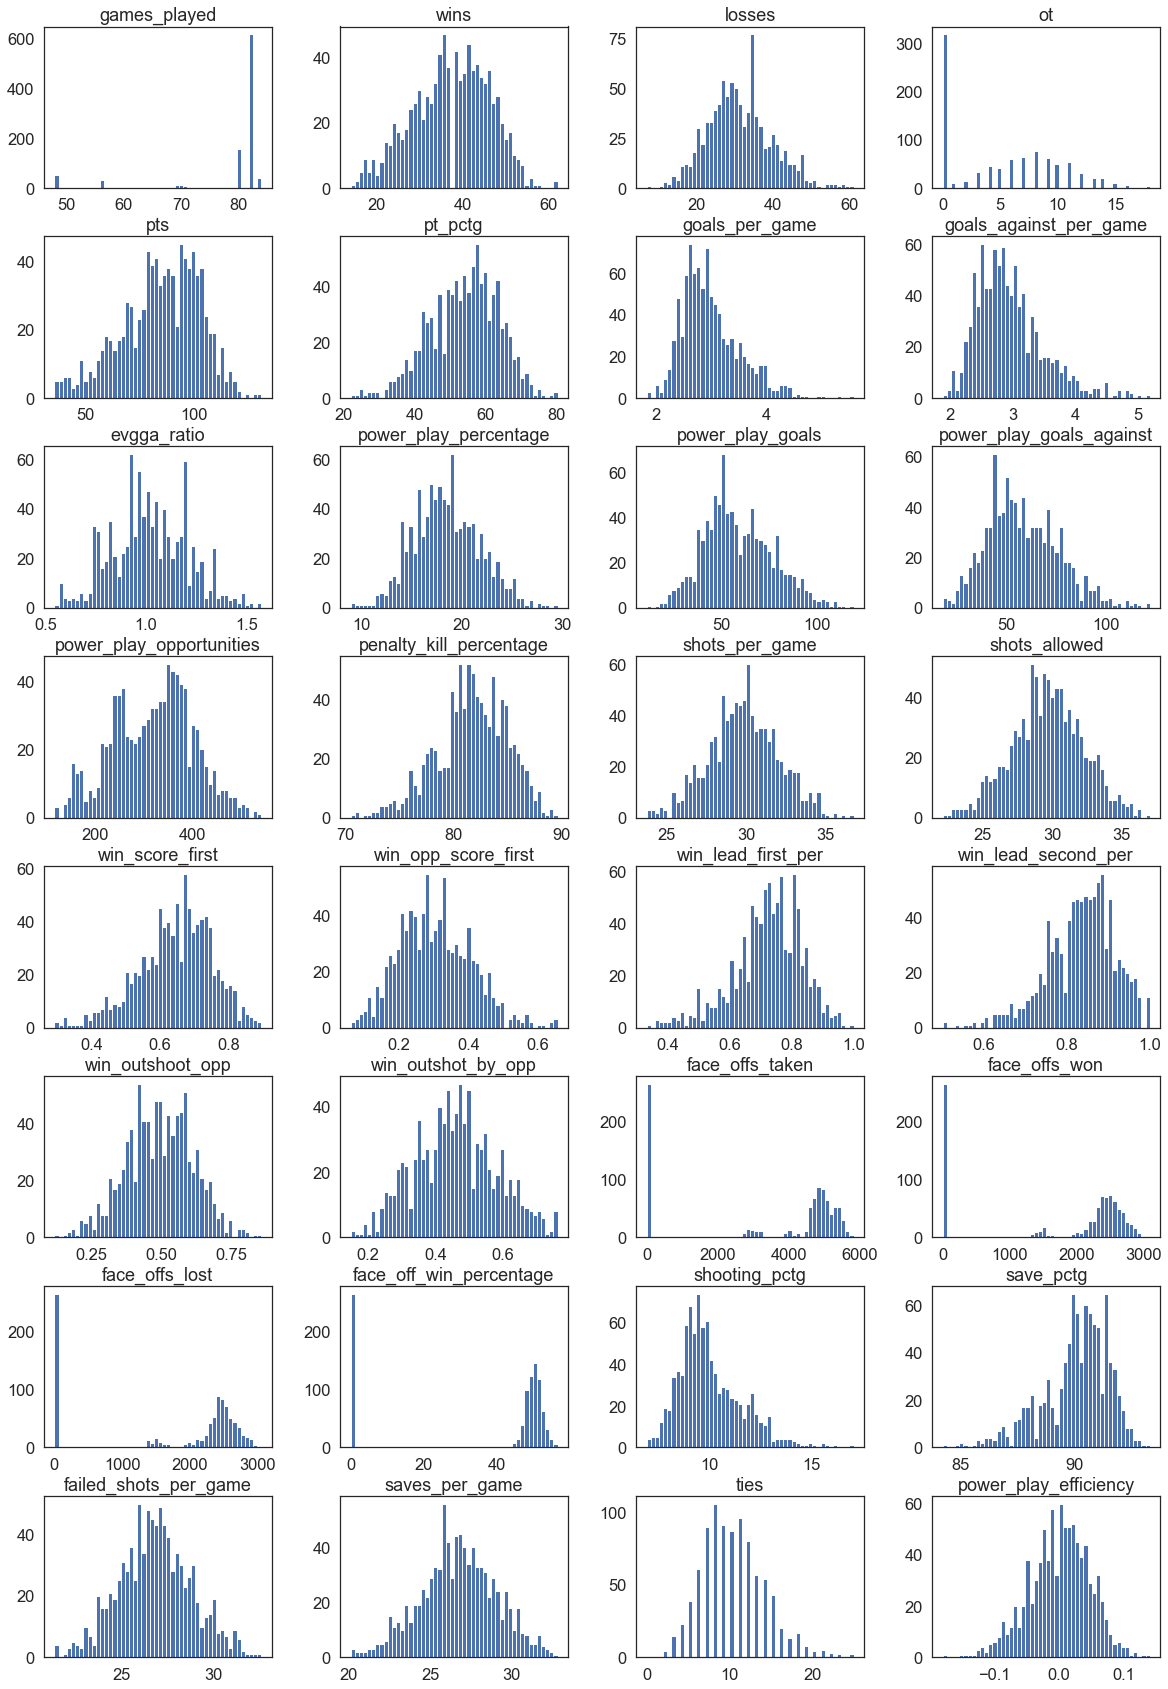


X continuous descriptive stats:


,count,mean,std,min,25%,50%,75%,max
games_played,922.0,78.626898,8.944251,48.000000,80.000000,82.000000,82.000000,84.000000
wins,922.0,37.216920,8.883039,14.000000,31.000000,38.000000,44.000000,62.000000
losses,922.0,31.213666,8.367827,7.000000,26.000000,30.000000,36.000000,61.000000
ot,922.0,5.248373,4.710526,0.000000,0.000000,5.000000,9.000000,18.000000
pts,922.0,84.630152,17.824421,36.000000,73.000000,87.000000,98.000000,131.000000
pt_pctg,922.0,53.847180,9.622141,22.000000,47.600000,54.900000,61.000000,80.200000
goals_per_game,922.0,2.982909,0.527838,1.829000,2.610000,2.878000,3.268000,5.575000
goals_against_per_game,922.0,2.951631,0.529185,1.890000,2.561000,2.854000,3.211500,5.188000
evgga_ratio,922.0,1.017060,0.189684,0.544400,0.896650,1.006900,1.156425,1.575200
power_play_percentage,922.0,18.449783,3.285398,8.900000,16.100000,18.300000,20.700000,29.500000


In [6]:
# Distributions of numeric continuous perdictor variables
num_univariate_histogram(
    df = nhl_df, 
    length = 30, 
    width = 20, 
    rows = 8, 
    col = 4,
    font = 1.5,
    kind = 1
)

<h3>The numeric features that will not be used due to no value added or model diminished  reliability:</h3>

* **Games played (games_played)** - Due to strikes and Covid-19, there are shortened seasons in the range of 48 - 70 games played. No significant adjustments will be made because this will not affect the analysis.<br><br>

* **Losses (losses)** - Intuitively, losses will not be included in the analysis because this feature simply is the opposite of the target variable and will generate no added value.<br><br>

* **Wins (wins, win_opp_score_first, win_lead_first_per, win_lead_second_per, win_outshoot_opp, win_outshot_by_opp)** - Intuitively, the target variable is generated with the wins variable and so by using wins, the model will be unreliable. Additionally these are strongly correlated with adjWins and can most likely be explained by the variance in the most predictive variables.<br><br>

* **Points (pts)** - Intuitively, points will not be included in the analysis for similar reasons as losses.<br><br>

* **Point percentage (pt_pctg)** - Intuitively, point percentage will not be included in the analysis for similar reasons as losses.<br><br>

* **EVGGARatio (evgga_ratio)** - EVGGARatio will not be included in the analysis because, despite the possibility it may provide predictive value, the metric remains unknown. If a decent result cannot be generated, this feature may be re-included to try and achieve better results.<br><br>

* **Power-play goals (power_play_goals)** - Power play goals will not be included because it is out of a team's direct control. Penalties only occur when officials call them against an opposing team.<br><br>

* **Power-play goals-against (power_play_goals_against)** - Power-play goals against will not be included in the analysis for similar reasons as power-play goals.<br><br>

* **Power-play opportunities (power_play_opportunities)** - Power play opportunities will not be included in the analysis for similar reasons as power-play goals.<br><br>

* **Overtime (ot)** - There are many missing data records or simply overtime was not played during the earlier seasons. This feature will produce misleading results and will not be included in the analysis. Additionally, ot instances are poorly correlated with adjWins.<br><br>

* **Face-off features (all)** - All features regarding face-offs will not be included in the analysis because of missing data records in the earlier seasons. Additionally, face-off features instances are poorly correlated with adjWins.


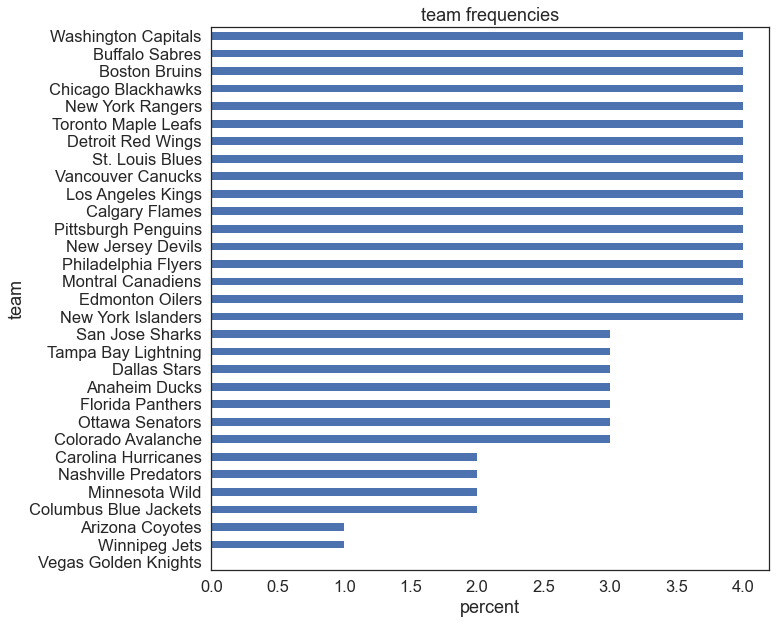

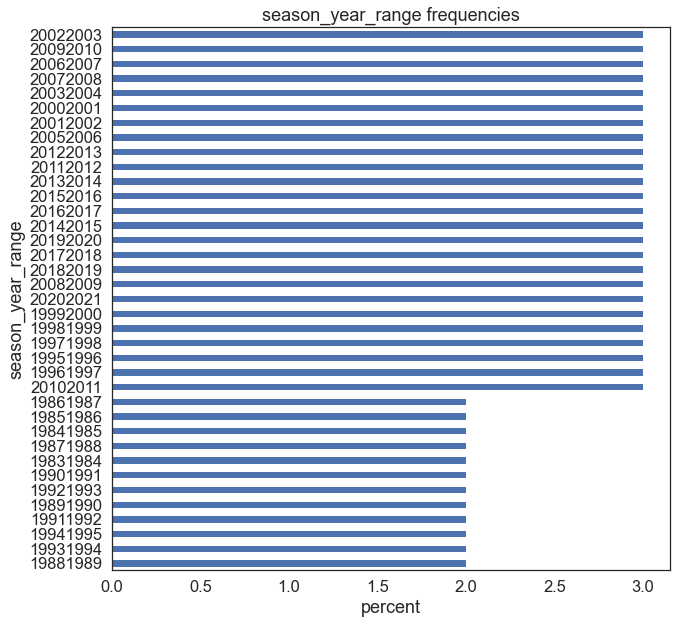

,count,unique
team,922,31
season_year_range,922,37


In [7]:
# View frequencies of categorical data
cat_univariate_freq(
    df = nhl_df, 
    length = 10, 
    width = 10, 
    col_start = 0, 
    col_end = 4, 
    font = 1.5
)

describe = nhl_df.describe(include = object)
describe = describe.T
describe = describe.drop(
    ['top', 'freq'], 
    axis = 1, 
    errors = 'ignore'
)

describe

The frequencies for the categorical features are plotted above, however, winScoreFirstGreater61 is the only feature of to be included in the analysis. 

Year range and team names will not generate any added value because the analysis is looking to help teams understand what metrics they can focus on to improve their seaon outcomes.

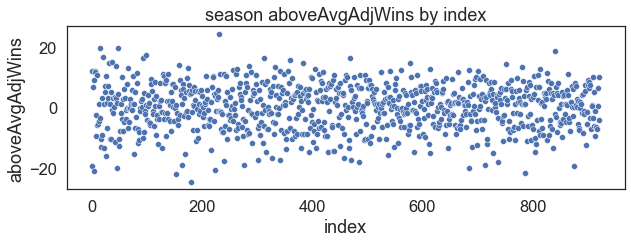

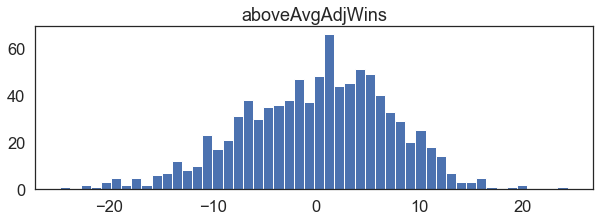


X continuous descriptive stats:


,count,mean,std,min,25%,50%,75%,max
aboveAvgAdjWins,922.0,-1.618373e-16,7.333648,-24.717391,-4.911765,0.660256,5.086207,24.3125



normality test:

statistic: 0.0
p-value: 13.71



In [8]:
# aboveAvgAdjWins by index scatter plot
target_univariate_scatter(
    df = nhl_df, 
    x = 'index', 
    y = 'aboveAvgAdjWins', 
    length = 3, 
    width = 10, 
    font = 1.5
)

# aboveAvgAdjWins variable distribution
y_hist = nhl_df.copy()
y_hist = y_hist[['aboveAvgAdjWins']]

num_univariate_histogram(
    df = y_hist,
    length = 3, 
    width = 10,
    rows = 1, 
    col = 1, 
    font = 1.5,
    kind = 2
)

print(
    '\n' + 'normality test:' +  '\n' + '\n' + 'statistic: ' + 
    str(round(normaltest(y_hist['aboveAvgAdjWins'].values)[1], 2)) +
    '\n' + 'p-value: ' + str(round(normaltest(y_hist['aboveAvgAdjWins'].values)[0],2)) + '\n'
)

The target variable (aboveAvgAdjWins) appears to be normally distributed, as shown by the histogram and the large p-value. The normality also proves that a better model than the mean can be produced. 

Through the histogram and scatter plot, it appears that there are no significant outliers in the data, allowing for a more robust model; additionally, the target variable is random shows no apparent bias by the scatter plot.

In [9]:
# Kept features

remove_features = np.array([
    'team', 
    'season_year_range', 
    'games_played',
    'wins', 
    'losses', 
    'pts',
    'pt_pctg',
    'evgga_ratio',
    'power_play_goals', 
    'power_play_goals_against',
    'power_play_opportunities',
    'name','year_range',
    'win_opp_score_first', 
    'win_lead_first_per', 
    'win_lead_second_per', 
    'win_outshoot_opp',
    'win_outshot_by_opp',
    'win_score_first',
    'face_offs_won', 
    'face_offs_taken', 
    'face_offs_lost', 
    'ot',
    'face_off_win_percentage'
])

print('removed features due to no value added: '+'\n'+'\n'+ str(remove_features))

removed features due to no value added: 

['team' 'season_year_range' 'games_played' 'wins' 'losses' 'pts' 'pt_pctg'
 'evgga_ratio' 'power_play_goals' 'power_play_goals_against'
 'power_play_opportunities' 'name' 'year_range' 'win_opp_score_first'
 'win_lead_first_per' 'win_lead_second_per' 'win_outshoot_opp'
 'win_outshot_by_opp' 'win_score_first' 'face_offs_won' 'face_offs_taken'
 'face_offs_lost' 'ot' 'face_off_win_percentage']


In [10]:
# Data frame with kept features
nhl_df = nhl_df.drop(
    remove_features, 
    axis = 1, 
    errors = 'ignore')

# Print data summary
print('\n')
nhl_df.info()
nhl_df.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 922 entries, 0 to 921
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   goals_per_game           922 non-null    float64
 1   goals_against_per_game   922 non-null    float64
 2   power_play_percentage    922 non-null    float64
 3   penalty_kill_percentage  922 non-null    float64
 4   shots_per_game           922 non-null    float64
 5   shots_allowed            922 non-null    float64
 6   shooting_pctg            922 non-null    float64
 7   save_pctg                922 non-null    float64
 8   failed_shots_per_game    922 non-null    float64
 9   saves_per_game           922 non-null    float64
 10  ties                     922 non-null    int64  
 11  power_play_efficiency    922 non-null    float64
 12  aboveAvgAdjWins          922 non-null    float64
dtypes: float64(12), int64(1)
memory usage: 100.8 KB


,goals_per_game,goals_against_per_game,power_play_percentage,penalty_kill_percentage,shots_per_game,shots_allowed,shooting_pctg,save_pctg,failed_shots_per_game,saves_per_game,ties,power_play_efficiency,aboveAvgAdjWins
0,2.888,4.375,14.3,75.3,26.3875,32.0000,10.9,86.3,23.511263,27.616000,7,-0.085399,-19.470588
1,4.463,3.363,22.5,81.5,30.2750,33.3875,14.7,89.9,25.824575,30.015363,4,-0.010714,12.029412
2,3.925,3.800,25.1,78.1,31.8875,31.5500,12.3,88.0,27.965338,27.764000,9,-0.006780,6.529412
3,4.375,3.625,20.2,76.6,36.7500,28.6500,11.9,87.3,32.376750,25.011450,10,-0.066246,9.029412
4,3.175,4.875,20.9,76.0,28.3375,36.3500,11.2,86.6,25.163700,31.479100,6,-0.044248,-20.970588


Above is a data frame with features that will be included in the analysis from this point on.

#### Bivariate Analysis

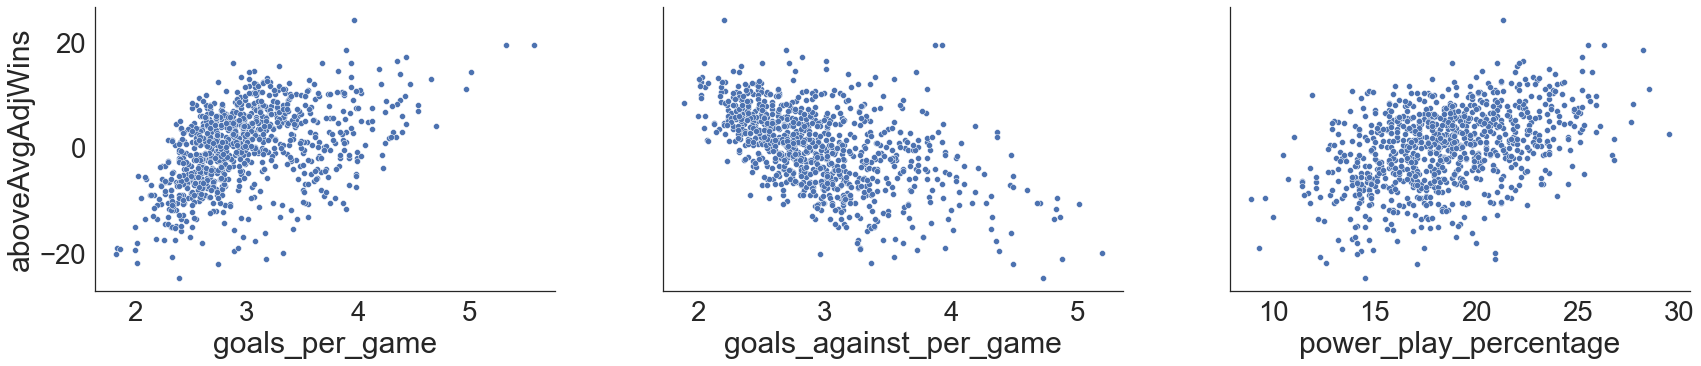

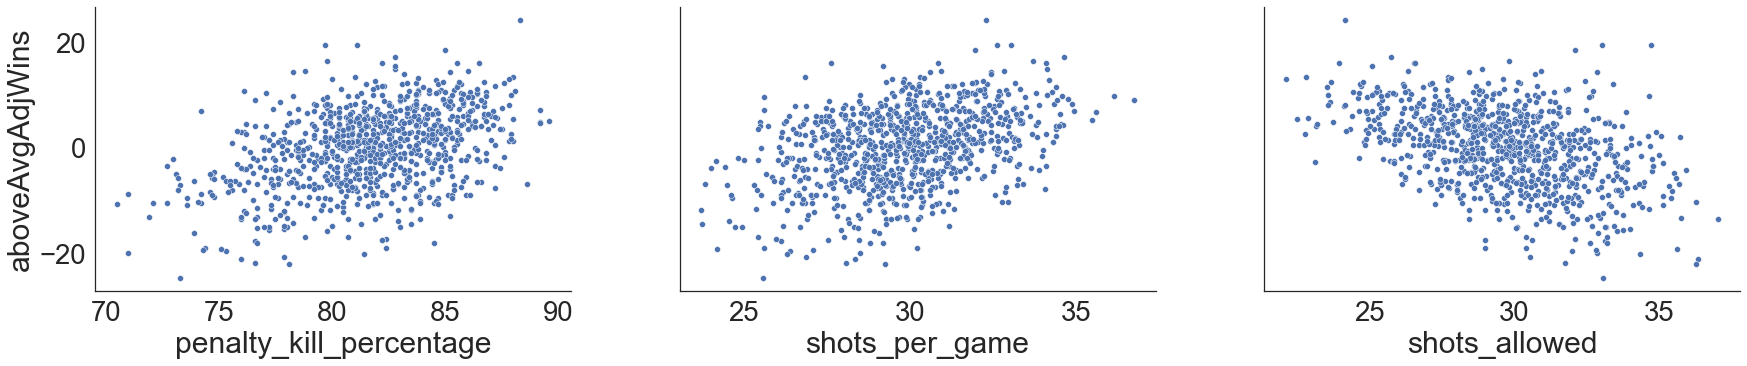

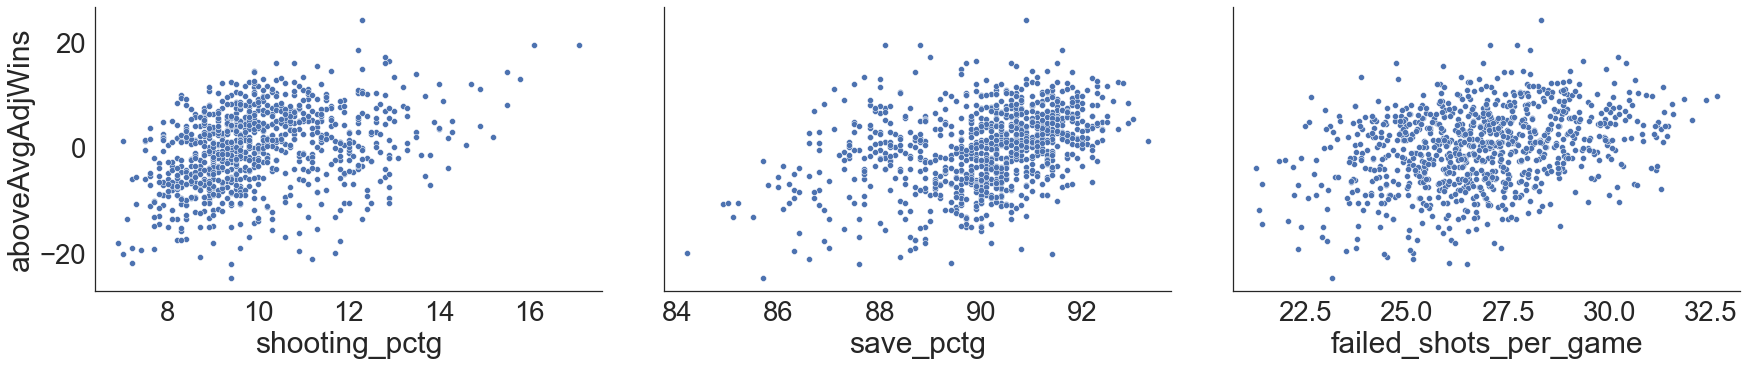

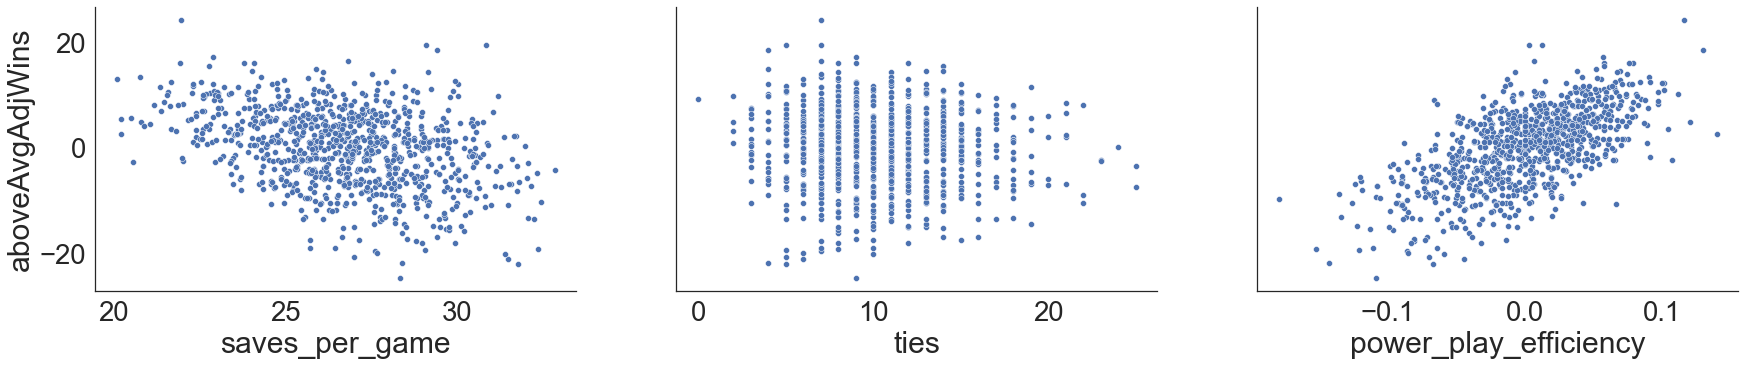

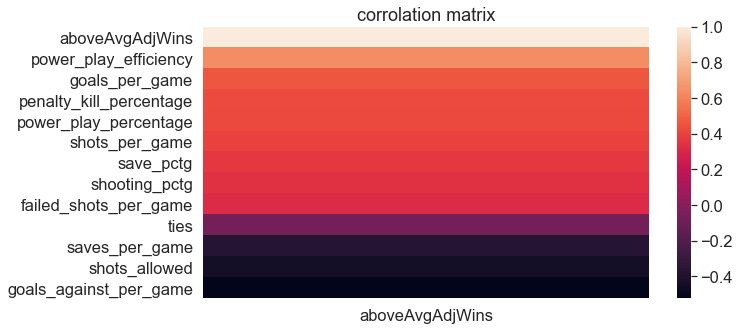

,aboveAvgAdjWins
aboveAvgAdjWins,1.000000
power_play_efficiency,0.642498
goals_per_game,0.463649
penalty_kill_percentage,0.423413
power_play_percentage,0.421213
shots_per_game,0.402204
save_pctg,0.365382
shooting_pctg,0.342972
failed_shots_per_game,0.318977
ties,-0.066463



features to remove: 
['ties']


In [25]:
# Feature relationship comparison with aboveAvgAdjWins via scatter plots
X_num = nhl_df.copy()
X_num = X_num.select_dtypes(include = ['float64', 'int64'])
X_num = X_num.columns[0:len(X_num.columns)-1]

num_bivariate_scatter(
    df = nhl_df, 
    y = 'aboveAvgAdjWins',
    x = X_num[0:3], 
    font = 2.5, 
    length = 10, 
    width = 30
)

num_bivariate_scatter(
    df = nhl_df, 
    y = 'aboveAvgAdjWins',
    x = X_num[3:6], 
    font = 2.5, 
    length = 10, 
    width = 30
)

num_bivariate_scatter(
    df = nhl_df, 
    y = 'aboveAvgAdjWins',
    x = X_num[6:9], 
    font = 2.5, 
    length = 10, 
    width = 30
)


num_bivariate_scatter(
    df = nhl_df,
    y = 'aboveAvgAdjWins', 
    x = X_num[9:13], 
    font = 2.5, 
    length = 10, 
    width = 30
)

# Feature relationship comparison with aboveAvgAdjWins via corrolation heat map
X_num = nhl_df.select_dtypes(include = ['float64', 'int64'])

num_bivariate_corr_target(
    df = X_num, 
    target = 'aboveAvgAdjWins', 
    threshold = 0.20, 
    font = 1.5, 
    length = 5, 
    width = 10
)

The above displays the bivariate analysis for the numeric continuous features with the target variable. 

We can visually see the relationships via scatter plot, heat map, and data frame. 

the **ties** features noticeably has a very weak relationship with aboveAvgAdjWins and will likely be removed form the data set.

In [18]:
# Export the final data frame to local directory 
nhl_df.to_csv('Data/NHL_1983_2021_Perprocessed_Season_Data_Removed_Outliers.csv', index = False)

The newly formed data frame is exported to the project directory for further analysis.